In [38]:
# Physics-Informed Neural Network for Periodic Advection Equation (Exercise 3)

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Use double precision for better accuracy
torch.set_default_dtype(torch.float64)

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 1)
        )

    def forward(self, x, t):
        xt = torch.cat((x, t), dim=1)
        return self.net(xt)

# Gradient function for autograd
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]

# Loss function for periodic advection problem
def loss_fn(model, x, t, eps):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = grad(u, t)
    u_x = grad(u, x)
    u_xx = grad(u_x, x)
    u_squared = u * u
    u_squared_x = grad(u_squared, x)

    # PDE residual
    f = u_t + 0.5 * u_squared_x - eps * u_xx

    # Define t values for BCs
    t_bc = torch.linspace(tmin, tmax, 200, device=device).unsqueeze(1)

    # Homogeneous boundary conditions: u(-1, t) = u(1, t) = 0
    bcL = model(torch.full_like(t_bc, -1), t_bc)
    bcR = model(torch.full_like(t_bc, 1), t_bc)

    # Initial condition: u(x, 0) = -sin(pi*x)
    ic = model(x, torch.zeros_like(t)) + torch.sin(np.pi * x)

    # Compute losses
    loss_pde = torch.mean(f**2)
    loss_bc = torch.mean(bcL**2 + bcR**2)
    loss_ic = torch.mean(ic**2)

    return loss_pde + 10.0 * loss_bc + 10.0 * loss_ic


# Training function
def train(model, epochs, optimizer, x, t, eps):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x, t, eps)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Domain settings
eps = 0.01/np.pi  # Diffusion coefficient
xmin, xmax, nx = -1, 1, 200
tmin, tmax, nt = 0, 1.6037/np.pi, 200

x = torch.linspace(xmin, xmax, nx, device=device).unsqueeze(1)
t = torch.linspace(tmin, tmax, nt, device=device).unsqueeze(1)
x_mesh, t_mesh = torch.meshgrid(x.flatten(), t.flatten(), indexing='ij')
x_mesh = x_mesh.reshape(-1, 1)
t_mesh = t_mesh.reshape(-1, 1)

# Initialize model and optimizer
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, 15000, optimizer, x_mesh, t_mesh, eps)


Using device: cpu
Epoch 0: Loss = 5.164285
Epoch 100: Loss = 3.584589
Epoch 200: Loss = 0.540500
Epoch 300: Loss = 0.521229
Epoch 400: Loss = 0.520052
Epoch 500: Loss = 0.485344
Epoch 600: Loss = 0.455634
Epoch 700: Loss = 0.404694
Epoch 800: Loss = 0.326736
Epoch 900: Loss = 0.262725
Epoch 1000: Loss = 0.212696
Epoch 1100: Loss = 0.187112
Epoch 1200: Loss = 0.177613
Epoch 1300: Loss = 0.171130
Epoch 1400: Loss = 0.165177
Epoch 1500: Loss = 0.168093
Epoch 1600: Loss = 0.153465
Epoch 1700: Loss = 0.148949
Epoch 1800: Loss = 0.141318
Epoch 1900: Loss = 0.135904
Epoch 2000: Loss = 0.130820
Epoch 2100: Loss = 0.126718
Epoch 2200: Loss = 0.153001
Epoch 2300: Loss = 0.119897
Epoch 2400: Loss = 0.116830
Epoch 2500: Loss = 0.114804
Epoch 2600: Loss = 0.110959
Epoch 2700: Loss = 0.108246
Epoch 2800: Loss = 0.105490
Epoch 2900: Loss = 0.102898
Epoch 3000: Loss = 0.100406
Epoch 3100: Loss = 0.097585
Epoch 3200: Loss = 0.094784
Epoch 3300: Loss = 0.091721
Epoch 3400: Loss = 0.089671
Epoch 3500: Lo

KeyboardInterrupt: 

In [39]:

# Prediction and visualization
model.eval()
with torch.no_grad():
    u_pred = model(x_mesh, t_mesh).cpu().numpy()

x_cpu = x.cpu().numpy().flatten()
t_cpu = t.cpu().numpy().flatten()
x_edges = np.append(x_cpu, x_cpu[-1] + (x_cpu[1] - x_cpu[0])) - (x_cpu[1] - x_cpu[0]) / 2
t_edges = np.append(t_cpu, t_cpu[-1] + (t_cpu[1] - t_cpu[0])) - (t_cpu[1] - t_cpu[0]) / 2


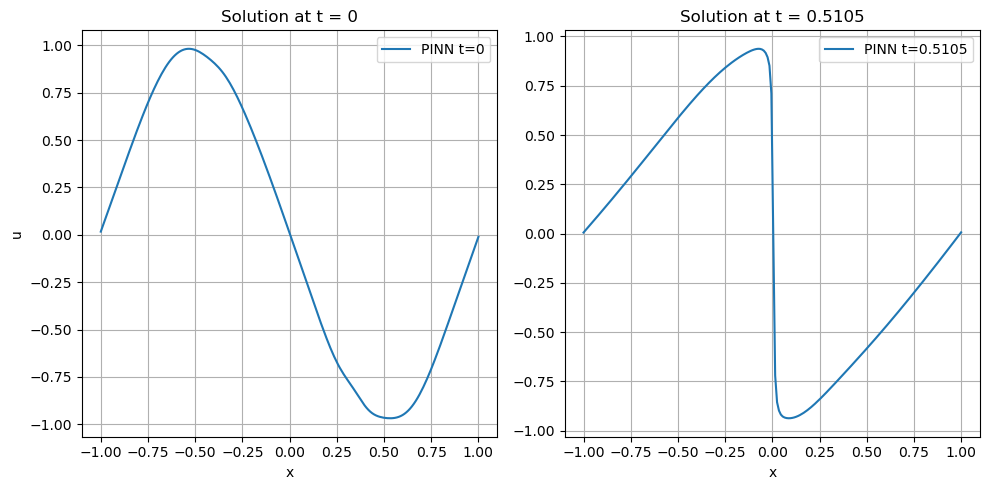

In [40]:
# Prepare spatial grid x for t=0 and t=tmax
x_plot = torch.linspace(xmin, xmax, nx, device=device).unsqueeze(1)

# Time tensors
t0 = torch.zeros_like(x_plot)
t_end = torch.full_like(x_plot, tmax)

# Predict at t=0 and t=tmax
with torch.no_grad():
    u_t0 = model(x_plot, t0).cpu().numpy()
    u_tend = model(x_plot, t_end).cpu().numpy()

# Exact solutions
x_np = x_plot.cpu().numpy()

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_np, u_t0, '-', label='PINN t=0')
plt.title("Solution at t = 0")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_np, u_tend, '-', label=f'PINN t={tmax:.4f}')
plt.title(f"Solution at t = {tmax:.4f}")
plt.xlabel("x")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [41]:
# Create a single point: x=0, t=tmax
x0 = torch.tensor([[0.0]], device=device, requires_grad=True)
t_end = torch.tensor([[tmax]], device=device)

# Forward pass
u = model(x0, t_end)

# Compute du/dx at that point
u_x = torch.autograd.grad(u, x0, grad_outputs=torch.ones_like(u), create_graph=True)[0]

# Extract the value
print(f"∂u/∂x at x=0, t={tmax:.4f} ≈ {u_x.item():.6f}")


∂u/∂x at x=0, t=0.5105 ≈ -72.724015
